In [1]:
import gym
import hiive.mdptoolbox, hiive.mdptoolbox.example, hiive.mdptoolbox.mdp
import hiive.mdptoolbox as mdptoolbox
import hiive.visualization
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt


np.random.seed(42) 
# set this so that in QL taking random actions based upon the value of epsilon, 
# you're generating random numbers consistently to compare against epsilon

N_EPISODES = 1000

In [4]:
def setup_game():
    # 8x8
    # from gym implementation
    MAPS = {
        '4x4': ['SFFH',
                'FHFF',
                'FFFF',
                'HFFG'
        ],
        '8x8': ["SFFFFFFF",
                "FFFFFFFF",
                "FFFHFFFF",
                "FFFFFHFF",
                "FFFHFFFF",
                "FHHFFFHF",
                "FHFFHFHF",
                "FFFHFFFG"],
        '12x12': ['SFFFFHHFFHFF', 'FFFFFFFFFFFF', 'HFFFFFFFHHFF', 'FFFFFFFFHFFF', 
                  'FFFFFFHHFFFH', 'HFFFFFFFFFFF', 'FFFFHFHFHHHH', 'FFFFFFFHFFFH', 
                  'FFFFFFFHHHFF', 'FFFFFFHFFFFH', 'FFHFHFFFFFFF', 'FFFHFFFFHFFG']
            }

    # order from ai gym for my sanity
    actions = ['LEFT', 'DOWN', 'RIGHT', 'UP']

    # Environment
    # from https://gym.openai.com/docs/
    # https://www.kaggle.com/angps95/intro-to-reinforcement-learning-with-openai-gym
    curr_map = MAPS['8x8']
    #curr_map = MAPS['12x12']
    env = gym.make('FrozenLake-v0', desc=curr_map)

    # check environment
    env.render()

    # Set up transition and rewards matrices
    env.reset() # just to be sure we're at the start state in the grid world
    n_size = env.nS
    print("# States: " + str(n_size))
    n_action = env.nA
    print("# Actions: " + str(n_action))

    # for visualization later
    env_state = []
    for r in curr_map:
        env_state.append(list(r))

    # from MDP docs, use numpy array that has the shape (A, S, S) for reward and trans
    trans = np.zeros([n_action, n_size, n_size])
    #reward = np.zeros((n_action, n_size, n_size))
    reward = np.zeros([n_size, n_action])

    # P is the transition matrix
    for s, s_info in env.P.items():
        for a, a_info in s_info.items():
            for i, info in enumerate(a_info):
                p = info[0]
                s_prime = info[1]
                r = info[2]
                reward[s, a] = r
                trans[a, s, s_prime] += p
            trans[a, s, :] /= np.sum(trans[a, s, :])

    # confirm that we have a valid reward and transition matrix
    mdptoolbox.util.check(trans, reward)
    return env, trans, reward, env_state



SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
# States: 64
# Actions: 4


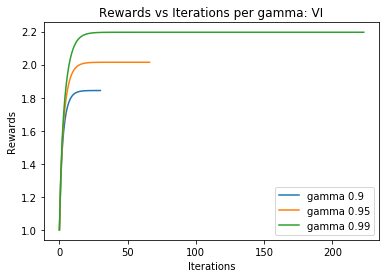

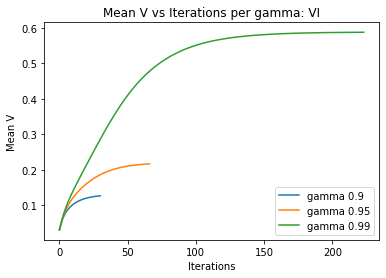

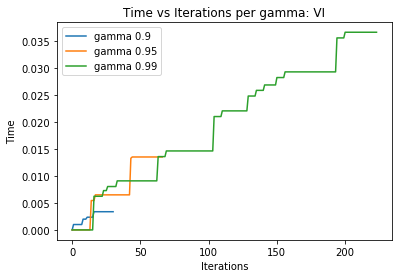

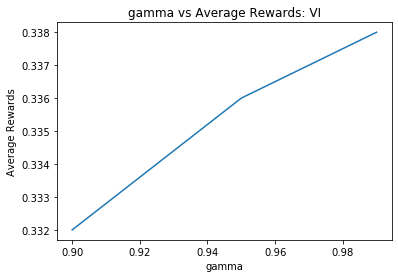

In [5]:
# Value Iteration
env, trans_m, reward_m, env_state = setup_game()
# hparams tuning
# gamma
gamma = [.9, .95, .99]

#stopping factor
#epsilon = [.01, .001, .0001, .00001]


# test each policy by playing the game, step x step, taking the optimal action in the policy
max_moves = 1000
avg_episode_rewards = []
for g in gamma:
    vi = mdptoolbox.mdp.ValueIteration(trans_m, reward_m, epsilon=.01 ,gamma=g)
    vi.run()
    episode_results = []
    episode_rewards = []
    # play game
    for i_episode in range(N_EPISODES):
        state = env.reset() # reset state to s0.
        moves = 0
        done = False
        total_rewards = 0
        while not done:
            action = vi.policy[state]
            state, reward, done, info = env.step(action)
            moves += 1
            total_rewards += reward
            if done:
                break
            if moves > max_moves:
                break       
        env.close()
        episode_rewards.append(total_rewards)
    ave_rewards = sum(episode_rewards) / N_EPISODES
    avg_episode_rewards.append(ave_rewards)
        
    
    reward_stats = [stat['Reward'] for stat in vi.run_stats]
    plt.figure(1)
    plt.plot(range(0, vi.iter), reward_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Rewards vs Iterations per gamma: VI")
    plt.ylabel("Rewards")
    plt.xlabel("Iterations")
    plt.savefig('../images/vi_frozen/Rewards_vs_Iterations_vi_gamma.png')
    
    
    meanv_stats = [stat['Mean V'] for stat in vi.run_stats]
    plt.figure(2)
    plt.plot(range(0, vi.iter), meanv_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Mean V vs Iterations per gamma: VI")
    plt.ylabel("Mean V")
    plt.xlabel("Iterations")
    plt.savefig('../images/vi_frozen/MeanV_vs_Iterations_vi_gamma.png')
    
    time_stats = [stat['Time'] for stat in vi.run_stats]
    plt.figure(3)
    plt.plot(range(0, vi.iter), time_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Time vs Iterations per gamma: VI")
    plt.ylabel("Time")
    plt.xlabel("Iterations")
    plt.savefig('../images/vi_frozen/Time_vs_Iterations_vi_gamma.png')
    
    
plt.figure(4)
plt.plot(gamma, avg_episode_rewards)
plt.title("gamma vs Average Rewards: VI")
plt.xlabel("gamma")
plt.ylabel("Average Rewards")
plt.savefig('../images/vi_frozen/Average_Rewards_vs_Gamma_vi.png')
    
    

iterations:224
Time: 0.031117677688598633
Policy: (3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 2, 0, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0)
[[3 2 2 2 2 2 2 2]
 [3 3 3 3 3 2 2 1]
 [3 3 0 0 2 3 2 1]
 [3 3 3 1 0 0 2 2]
 [0 3 0 0 2 1 3 2]
 [0 0 0 1 3 0 0 2]
 [0 0 1 0 0 0 0 0]
 [0 1 0 0 1 1 1 0]]


c:\users\spcbe\miniconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


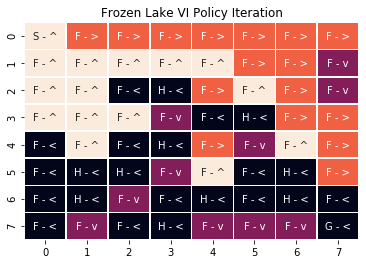

In [11]:
# Show Optimal policy
vi = mdptoolbox.mdp.ValueIteration(trans_m, reward_m, epsilon=.01 ,gamma=.99)
vi.run()
print('iterations:' + str(vi.iter))
print('Time: ' + str(vi.time))
print('Policy: ' + str(vi.policy))
visualize_policy(vi.policy, rl_type='VI', env_state=env_state)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
# States: 64
# Actions: 4


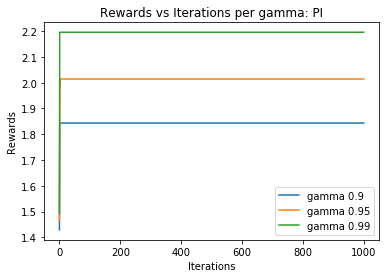

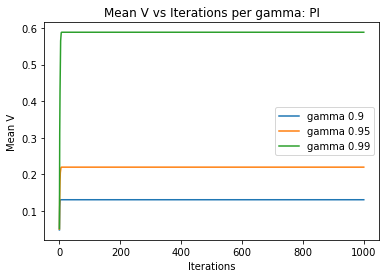

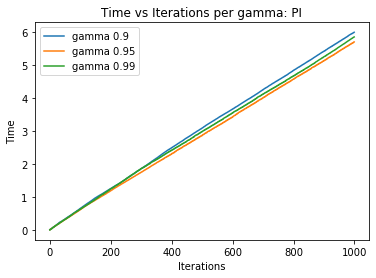

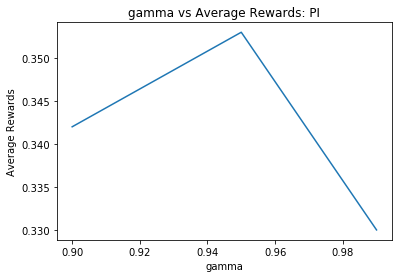

In [12]:
# Policy Iteration
env, trans_m, reward_m, env_state = setup_game()
# hparams tuning
# gamma
gamma = [.9, .95, .99]

#stopping factor
#epsilon = [.01, .001, .0001, .00001]


# test each policy by playing the game, step x step, taking the optimal action in the policy
max_moves = 1000
avg_episode_rewards = []
for g in gamma:
    pi = mdptoolbox.mdp.PolicyIteration(trans_m, reward_m, gamma=g)
    pi.run()
    episode_results = []
    episode_rewards = []
    # play game
    for i_episode in range(N_EPISODES):
        state = env.reset() # reset state to s0.
        moves = 0
        done = False
        total_rewards = 0
        while not done:
            action = pi.policy[state]
            state, reward, done, info = env.step(action)
            moves += 1
            total_rewards += reward
            if done:
                break
            if moves > max_moves:
                break       
        env.close()
        episode_rewards.append(total_rewards)
    ave_rewards = sum(episode_rewards) / N_EPISODES
    avg_episode_rewards.append(ave_rewards)
        
    
    reward_stats = [stat['Reward'] for stat in pi.run_stats]
    plt.figure(1)
    plt.plot(range(0, pi.iter), reward_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Rewards vs Iterations per gamma: PI")
    plt.ylabel("Rewards")
    plt.xlabel("Iterations")
    plt.savefig('../images/pi_frozen/Rewards_vs_Iterations_pi_gamma.png')
    
    
    meanv_stats = [stat['Mean V'] for stat in pi.run_stats]
    plt.figure(2)
    plt.plot(range(0, pi.iter), meanv_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Mean V vs Iterations per gamma: PI")
    plt.ylabel("Mean V")
    plt.xlabel("Iterations")
    plt.savefig('../images/pi_frozen/MeanV_vs_Iterations_pi_gamma.png')
    
    time_stats = [stat['Time'] for stat in pi.run_stats]
    plt.figure(3)
    plt.plot(range(0, pi.iter), time_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Time vs Iterations per gamma: PI")
    plt.ylabel("Time")
    plt.xlabel("Iterations")
    plt.savefig('../images/pi_frozen/Time_vs_Iterations_pi_gamma.png')
    
    
plt.figure(4)
plt.plot(gamma, avg_episode_rewards)
plt.title("gamma vs Average Rewards: PI")
plt.xlabel("gamma")
plt.ylabel("Average Rewards")
plt.savefig('../images/pi_frozen/Average_Rewards_vs_Gamma_pi.png')
    

iterations:1000
Time: 5.93122673034668
Policy: (3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 2, 0, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 3, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 1, 0)
False
[[3 2 2 2 2 2 2 2]
 [3 3 3 3 3 2 2 1]
 [3 3 0 0 2 3 2 1]
 [3 3 3 1 0 0 2 2]
 [0 3 0 0 2 1 3 2]
 [0 0 0 1 3 0 0 2]
 [0 0 1 3 0 0 0 0]
 [0 1 0 0 2 1 1 0]]


c:\users\spcbe\miniconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


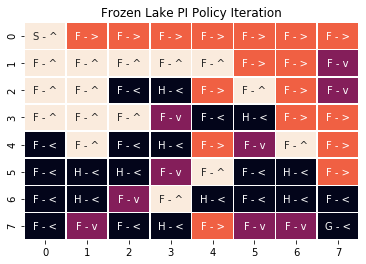

In [14]:
# Show Optimal policy
pi = mdptoolbox.mdp.PolicyIteration(trans_m, reward_m, gamma=.99)
pi.run()
print('iterations:' + str(pi.iter))
print('Time: ' + str(pi.time))
print('Policy: ' + str(pi.policy))
# Did they converge to the same policy?
print(vi.policy == pi.policy)
visualize_policy(pi.policy, rl_type='PI', env_state=env_state)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
# States: 64
# Actions: 4


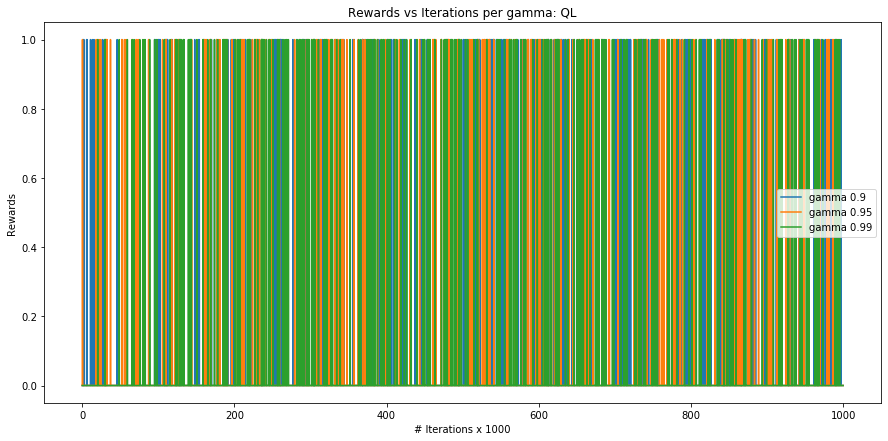

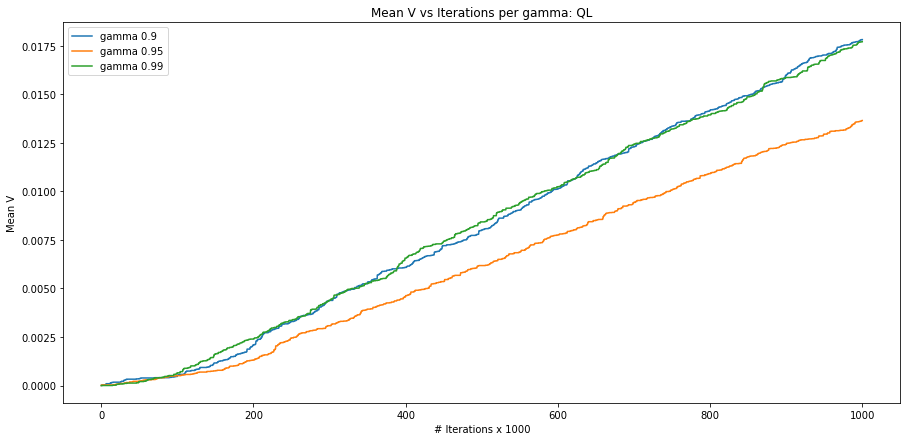

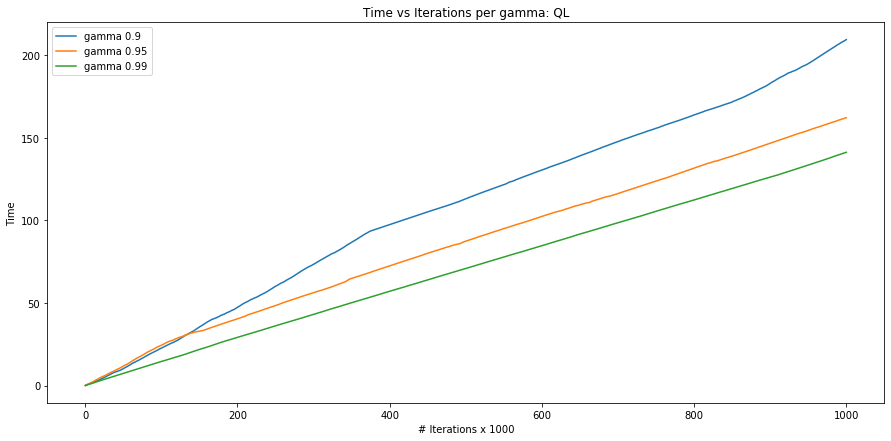

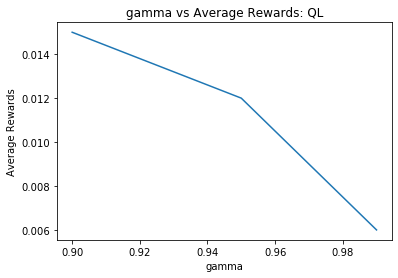

In [27]:
#QL
env, trans_m, reward_m, env_state = setup_game()
# hparams tuning
# gamma
gamma = [.9, .95, .99]

# test each policy by playing the game, step x step, taking the optimal action in the policy
max_moves = 1000
avg_episode_rewards = []
for g in gamma:
    ql = mdptoolbox.mdp.QLearning(trans_m, reward_m, gamma=g, n_iter=1000000)
    ql.run()
    episode_results = []
    episode_rewards = []
    # play game
    for i_episode in range(N_EPISODES):
        state = env.reset() # reset state to s0.
        moves = 0
        done = False
        total_rewards = 0
        while not done:
            action = ql.policy[state]
            state, reward, done, info = env.step(action)
            moves += 1
            total_rewards += reward
            if done:
                break
            if moves > max_moves:
                break       
        env.close()
        episode_rewards.append(total_rewards)
    ave_rewards = sum(episode_rewards) / N_EPISODES
    avg_episode_rewards.append(ave_rewards)
        
    # these numbers are huge. Try scaling down so they fit the x axis
    ql_iters = [stat['Iteration'] / 1000 for stat in ql.run_stats] 
    
    reward_stats = [stat['Reward'] for stat in ql.run_stats]
    plt.figure(1, figsize=[15, 7])
    plt.plot(ql_iters, reward_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Rewards vs Iterations per gamma: QL")
    plt.ylabel("Rewards")
    plt.xlabel("# Iterations x 1000")
    plt.savefig('../images/ql_frozen/Rewards_vs_Iterations_ql_gamma.png')
    
    
    meanv_stats = [stat['Mean V'] for stat in ql.run_stats]
    plt.figure(2, figsize=[15, 7])
    plt.plot(ql_iters, meanv_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Mean V vs Iterations per gamma: QL")
    plt.ylabel("Mean V")
    plt.xlabel("# Iterations x 1000")
    plt.savefig('../images/ql_frozen/MeanV_vs_Iterations_ql_gamma.png')
    
    time_stats = [stat['Time'] for stat in ql.run_stats]
    plt.figure(3, figsize=[15, 7])
    plt.plot(ql_iters, time_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Time vs Iterations per gamma: QL")
    plt.ylabel("Time")
    plt.xlabel("# Iterations x 1000")
    plt.savefig('../images/ql_frozen/Time_vs_Iterations_ql_gamma.png')
    
    
plt.figure(4)
plt.plot(gamma, avg_episode_rewards)
plt.title("gamma vs Average Rewards: QL")
plt.xlabel("gamma")
plt.ylabel("Average Rewards")
plt.savefig('../images/ql_frozen/Average_Rewards_vs_Gamma_ql.png')
    

Time: 143.53386187553406
Policy: (3, 3, 1, 3, 2, 1, 0, 2, 1, 2, 2, 2, 2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 1, 0, 1, 1, 3, 1, 0, 0, 1, 0, 3, 3, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 3, 2, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 2, 3, 0, 0, 2, 3, 1, 0)
False
False
[[3 3 1 3 2 1 0 2]
 [1 2 2 2 2 0 0 1]
 [2 1 2 0 2 2 1 0]
 [1 1 3 1 0 0 1 0]
 [3 3 0 0 2 1 1 0]
 [0 0 0 2 3 2 0 0]
 [3 0 3 0 0 0 0 0]
 [2 3 0 0 2 3 1 0]]


c:\users\spcbe\miniconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


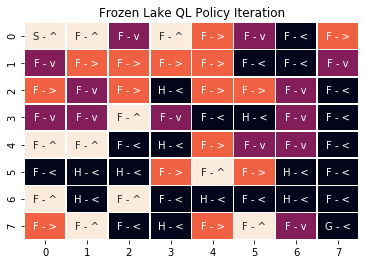

In [28]:
# Show Optimal policy
ql = mdptoolbox.mdp.QLearning(trans_m, reward_m, gamma=.9, n_iter=1000000)
ql.run()
print('Time: ' + str(ql.time))
print('Policy: ' + str(ql.policy))
# Did they converge to the same policy?
print(ql.policy == pi.policy)
print(ql.policy == vi.policy)
visualize_policy(ql.policy, rl_type='QL', env_state=env_state)

In [10]:
def visualize_policy(policy, rl_type, env_state):    
    action_taken = {0: '<', 1: 'v', 2: '>', 3: '^'}
    
    dim = int(np.sqrt(env.nS))
    state_arr = (dim, dim)
    # reshape tuple as array
    policy_arr = np.reshape(policy, state_arr)
    print(policy_arr)
    policy_labels = np.vectorize(action_taken.get)(policy)
    e_state = [item for sublist in env_state for item in sublist]
    

    for a in policy:
        # add the state labels
        temp = []
        for x, y in np.nditer([policy_labels, e_state]):
            x = ' - '.join([str(y), str(x)])
            temp.append(x)
    policy_labels = np.reshape(temp, state_arr)
    
    plot = sns.heatmap(policy_arr, annot=policy_labels, fmt='', linewidth=.6, cbar=False)
    title = f'Frozen Lake {rl_type} Policy Iteration' 
    plot.title.set_text(title)
    fig = plot.get_figure()
    fig.savefig('../images/' + rl_type.lower() + '_frozen/policy_frozen_' + rl_type + '_.png')
    fig.show()
    #fig.clf()
        

In [ ]:
# Taken as is from https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py
def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


In [ ]:
# Used to initially generate constant maps 
m = generate_random_map(size=30)
print(m)